In [1]:
import os
import math
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.weight_norm as weight_norm
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(42)

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Torch: 2.9.1+cu128
CUDA available: True


In [3]:
class Config:
    # Data
    DATA_PATH = '/root/autodl-tmp/ndx_data.csv' 

    # Sequence length 
    SEQ_LEN = 128

    # Training
    BATCH_SIZE = 64
    LR = 2e-4
    N_EPOCHS = 2000
    N_CRITIC = 5
    LAMBDA_GP = 10.0

    # Model
    LATENT_DIM = 10
    CHANNELS = [32, 32, 32, 32, 32, 32, 32]
    KERNEL_SIZE = 3
    DROPOUT = 0.05

    # Conditional settings
    N_REGIMES = 2
    COND_EMB_DIM = 16
    PROJ_EMB_DIM = CHANNELS[-1] 

    # Misc
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", Config.DEVICE)


Using device: cuda


In [4]:
# 2) Core TCN modules 
class Chomp1d(nn.Module):
    def __init__(self, chomp_size: int):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super().__init__()

        self.conv1 = weight_norm(nn.Conv1d(
            n_inputs, n_outputs, kernel_size,
            stride=stride, padding=padding, dilation=dilation
        ))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.LeakyReLU(0.2)
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(
            n_outputs, n_outputs, kernel_size,
            stride=stride, padding=padding, dilation=dilation
        ))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.LeakyReLU(0.2)
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(
            self.conv1, self.chomp1, self.relu1, self.dropout1,
            self.conv2, self.chomp2, self.relu2, self.dropout2
        )

        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu2(out + res)

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(
                in_channels, out_channels, kernel_size,
                stride=1, dilation=dilation_size,
                padding=(kernel_size - 1) * dilation_size,
                dropout=dropout
            )]
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


In [5]:
# 3) Data processing: windows + regime labels
def _read_prices_from_csv(path: str) -> np.ndarray:
    df = pd.read_csv(path)
    if 'Close' in df.columns:
        prices = df['Close'].astype(float).values
    else:
        prices = df.iloc[:, 1].astype(float).values
    return prices

def compute_log_returns(prices: np.ndarray) -> np.ndarray:
    prices = np.asarray(prices, dtype=np.float64)
    return np.diff(np.log(prices + 1e-12))

def make_regime_labels(raw_returns: np.ndarray, seq_len: int, n_regimes: int) -> np.ndarray:
    vols = []
    for i in range(len(raw_returns) - seq_len):
        w = raw_returns[i:i+seq_len]
        vols.append(np.std(w, ddof=1))
    vols = np.asarray(vols)

    if n_regimes == 2:
        thr = np.median(vols)
        y = (vols > thr).astype(np.int64)
        return y
    else:
        qs = np.linspace(0, 1, n_regimes + 1)[1:-1]
        bins = np.quantile(vols, qs)
        y = np.digitize(vols, bins, right=False).astype(np.int64)
        return y

class ReturnsWindowDataset(Dataset):
    def __init__(self, x_windows: torch.Tensor, y_labels: torch.Tensor):
        super().__init__()
        assert x_windows.ndim == 3 and x_windows.shape[1] == 1
        assert y_labels.ndim == 1 and x_windows.shape[0] == y_labels.shape[0]
        self.x = x_windows
        self.y = y_labels

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

def get_dataset_and_scaler():
    if not os.path.exists(Config.DATA_PATH):
        raise FileNotFoundError(f"Data file not found: {Config.DATA_PATH}")

    prices = _read_prices_from_csv(Config.DATA_PATH)
    raw_ret = compute_log_returns(prices)

    scaler = StandardScaler()
    ret_scaled = scaler.fit_transform(raw_ret.reshape(-1, 1)).flatten()

    X = []
    for i in range(len(ret_scaled) - Config.SEQ_LEN):
        X.append(ret_scaled[i:i+Config.SEQ_LEN])
    X = np.asarray(X, dtype=np.float32)  # (Nw, L)
    X = X[:, None, :]                    # (Nw, 1, L)

    y = make_regime_labels(raw_ret, Config.SEQ_LEN, Config.N_REGIMES)  # (Nw,)
    y = y.astype(np.int64)

    dataset = ReturnsWindowDataset(torch.from_numpy(X), torch.from_numpy(y))
    return dataset, scaler, raw_ret

dataset, scaler, raw_returns = get_dataset_and_scaler()
dataloader = DataLoader(dataset, batch_size=Config.BATCH_SIZE, shuffle=True, drop_last=True)

xs, ys = next(iter(dataloader))
print("Dataset windows:", len(dataset))
print("X batch:", xs.shape, xs.dtype)
print("y batch:", ys.shape, ys.dtype, "unique:", torch.unique(ys))

Dataset windows: 2638
X batch: torch.Size([64, 1, 128]) torch.float32
y batch: torch.Size([64]) torch.int64 unique: tensor([0, 1])


In [6]:
# 4) Conditional Generator: concat conditioning on the input channels
class CondGenerator(nn.Module):
    def __init__(self, n_regimes: int):
        super().__init__()
        self.cond_emb = nn.Embedding(n_regimes, Config.COND_EMB_DIM)

        self.tcn = TemporalConvNet(
            num_inputs=Config.LATENT_DIM + Config.COND_EMB_DIM,
            num_channels=Config.CHANNELS,
            kernel_size=Config.KERNEL_SIZE,
            dropout=Config.DROPOUT
        )
        self.output_layer = nn.Conv1d(Config.CHANNELS[-1], 1, kernel_size=1)

    def forward(self, z, y):
        # z: (B, LATENT_DIM, L), y: (B,)
        B, _, L = z.shape
        y_emb = self.cond_emb(y)      
        y_rep = y_emb.unsqueeze(-1).repeat(1, 1, L)
        z_cat = torch.cat([z, y_rep], dim=1)
        h = self.tcn(z_cat)
        return self.output_layer(h) 


In [7]:
# 5) Projection Discriminator / Critic
class ProjDiscriminator(nn.Module):
    def __init__(self, n_regimes: int):
        super().__init__()
        self.tcn = TemporalConvNet(
            num_inputs=1,
            num_channels=Config.CHANNELS,
            kernel_size=Config.KERNEL_SIZE,
            dropout=Config.DROPOUT
        )

        feat_dim = Config.CHANNELS[-1]
        assert Config.PROJ_EMB_DIM == feat_dim, "Config.PROJ_EMB_DIM must equal CHANNELS[-1]"

        self.linear = nn.Linear(feat_dim, 1)
        self.y_emb = nn.Embedding(n_regimes, feat_dim)

    def forward(self, x, y):
        # x: (B, 1, L), y: (B,)
        h_seq = self.tcn(x)         # (B, C, L)
        h = h_seq[:, :, -1]         # (B, C)
        out = self.linear(h)        # (B, 1)
        emb = self.y_emb(y)         # (B, C)
        proj = torch.sum(h * emb, dim=1, keepdim=True)  # (B, 1)
        return out + proj


In [8]:
# 6) WGAN-GP gradient penalty (conditioned)
def compute_gradient_penalty(D, real_samples, fake_samples, y):
    B = real_samples.size(0)
    alpha = torch.rand(B, 1, 1, device=Config.DEVICE)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    d_interpolates = D(interpolates, y)
    ones = torch.ones_like(d_interpolates, device=Config.DEVICE)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=ones,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    gradients = gradients.view(B, -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * Config.LAMBDA_GP
    return gp


In [9]:
# 7) Train
G = CondGenerator(Config.N_REGIMES).to(Config.DEVICE)
D = ProjDiscriminator(Config.N_REGIMES).to(Config.DEVICE)

opt_G = optim.Adam(G.parameters(), lr=Config.LR, betas=(0.5, 0.9))
opt_D = optim.Adam(D.parameters(), lr=Config.LR, betas=(0.5, 0.9))

print("Start Conditional P-RSQGAN (TCN + WGAN-GP + Projection Critic) training...")

G_losses, D_losses = [], []
global_step = 0

for epoch in range(1, Config.N_EPOCHS + 1):
    for (real_x, y) in dataloader:
        real_x = real_x.to(Config.DEVICE)
        y = y.to(Config.DEVICE)

        # ---- Train Critic ----
        opt_D.zero_grad(set_to_none=True)

        z = torch.randn(real_x.size(0), Config.LATENT_DIM, Config.SEQ_LEN, device=Config.DEVICE)
        fake_x = G(z, y)

        real_score = D(real_x, y)
        fake_score = D(fake_x.detach(), y)
        gp = compute_gradient_penalty(D, real_x, fake_x.detach(), y)

        d_loss = -torch.mean(real_score) + torch.mean(fake_score) + gp
        d_loss.backward()
        opt_D.step()

        # Train Generator
        if global_step % Config.N_CRITIC == 0:
            opt_G.zero_grad(set_to_none=True)

            z = torch.randn(real_x.size(0), Config.LATENT_DIM, Config.SEQ_LEN, device=Config.DEVICE)
            fake_x = G(z, y)

            g_loss = -torch.mean(D(fake_x, y))
            g_loss.backward()
            opt_G.step()

            G_losses.append(g_loss.item())
            D_losses.append(d_loss.item())

        global_step += 1

    if epoch % 100 == 0 or epoch == 1:
        g_last = G_losses[-1] if len(G_losses) else float('nan')
        d_last = D_losses[-1] if len(D_losses) else float('nan')
        print(f"[Epoch {epoch:4d}/{Config.N_EPOCHS}]  D: {d_last:.4f}  G: {g_last:.4f}")

print("Training finished.")

/root/miniconda3/envs/d2l-env/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Start Conditional P-RSQGAN (TCN + WGAN-GP + Projection Critic) training...
[Epoch    1/2000]  D: -3.6368  G: -2.0994
[Epoch  100/2000]  D: -1.4773  G: 0.4315
[Epoch  200/2000]  D: -1.1689  G: 9.6971
[Epoch  300/2000]  D: -1.0512  G: 8.9782
[Epoch  400/2000]  D: -2.0535  G: 8.5564
[Epoch  500/2000]  D: -1.9087  G: 8.1490
[Epoch  600/2000]  D: -2.2189  G: 5.9582
[Epoch  700/2000]  D: -2.4490  G: 6.0798
[Epoch  800/2000]  D: -2.0141  G: 5.9770
[Epoch  900/2000]  D: -1.7809  G: 5.0649
[Epoch 1000/2000]  D: -2.0406  G: 5.4341
[Epoch 1100/2000]  D: -2.9286  G: 3.8043
[Epoch 1200/2000]  D: -2.6664  G: 3.4035
[Epoch 1300/2000]  D: -2.6714  G: 3.0011
[Epoch 1400/2000]  D: -2.8177  G: 1.3268
[Epoch 1500/2000]  D: -2.5387  G: 2.1161
[Epoch 1600/2000]  D: -2.4701  G: 1.7904
[Epoch 1700/2000]  D: -2.6503  G: 0.9917
[Epoch 1800/2000]  D: -3.0845  G: 2.4248
[Epoch 1900/2000]  D: -2.3764  G: 1.9976
[Epoch 2000/2000]  D: -2.6360  G: 0.4787
Training finished.


In [21]:
# 8) Sampling utilities
@torch.no_grad()
def sample_returns(n_samples: int, regime: int):
    G.eval()
    z = torch.randn(n_samples, Config.LATENT_DIM, Config.SEQ_LEN, device=Config.DEVICE)
    y = torch.full((n_samples,), int(regime), dtype=torch.long, device=Config.DEVICE)

    gen_scaled = G(z, y).squeeze(1).cpu().numpy()
    gen_raw = scaler.inverse_transform(gen_scaled.reshape(-1, 1)).reshape(n_samples, Config.SEQ_LEN)
    return gen_scaled, gen_raw

gen0_scaled, gen0 = sample_returns(512, 0)
if Config.N_REGIMES > 1:
    gen1_scaled, gen1 = sample_returns(512, 1)

print("gen0:", gen0.shape)
if Config.N_REGIMES > 1:
    print("gen1:", gen1.shape)


gen0: (512, 128)
gen1: (512, 128)


In [22]:
# 9) Save generated arrays and weights
out_dir = "./outputs_cond_P-RSQGAN"
os.makedirs(out_dir, exist_ok=True)

np.save(os.path.join(out_dir, "gen_regime0.npy"), gen0)
if Config.N_REGIMES > 1:
    np.save(os.path.join(out_dir, "gen_regime1.npy"), gen1)

torch.save(G.state_dict(), os.path.join(out_dir, "G_cond_proj.pth"))
torch.save(D.state_dict(), os.path.join(out_dir, "D_proj.pth"))

In [23]:
# 10) Visualization
plt.style.use('seaborn-v0_8-whitegrid')

REGIME_TO_PLOT = 0 
GEN_SEQ_LEN = 1000   
S0 = 100.0    

def returns_to_index(returns, start_price):
    cumulative_returns = np.cumsum(returns)
    cumulative_returns = np.clip(cumulative_returns, -10, 10) 
    index = start_price * np.exp(cumulative_returns)
    return np.insert(index, 0, start_price)

real_data_scaled = dataset.x.numpy() 
real_returns_flat = scaler.inverse_transform(real_data_scaled[:, 0, :].reshape(-1, 1)).flatten()

real_returns_arr = real_returns_flat[:GEN_SEQ_LEN]
real_price_arr = returns_to_index(real_returns_arr, S0)

import torch

@torch.no_grad()
def sample_long_return_series(netG, regime_id, total_len, blocks_per_call=256):
    netG.eval()
    seq_len = Config.SEQ_LEN
    latent_dim = Config.LATENT_DIM

    # how many windows needed
    n_blocks = math.ceil(total_len / seq_len)

    outs = []
    remaining = n_blocks
    while remaining > 0:
        b = min(blocks_per_call, remaining)
        z = torch.randn(b, latent_dim, seq_len, device=Config.DEVICE)
        y = torch.full((b,), int(regime_id), dtype=torch.long, device=Config.DEVICE)
        fake = netG(z, y).detach().cpu().numpy().squeeze(1)   # (b, L)
        outs.append(fake)
        remaining -= b

    fake_scaled = np.concatenate(outs, axis=0).reshape(-1, 1)  # (n_blocks*L, 1)
    fake_ret = scaler.inverse_transform(fake_scaled).flatten()  # original scale
    return fake_ret[:total_len]

generated_returns = sample_long_return_series(G, REGIME_TO_PLOT, total_len=2000 * Config.SEQ_LEN)

n_simulations = 100
simulated_returns_paths = []
simulated_price_paths = []

target_mean = 0.0 

for _ in range(n_simulations):
    fake_ret = sample_long_return_series(G, REGIME_TO_PLOT, total_len=GEN_SEQ_LEN)
    fake_ret = fake_ret - np.mean(fake_ret) + target_mean
    simulated_returns_paths.append(fake_ret)
    simulated_price_paths.append(returns_to_index(fake_ret, S0))

percentiles = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95]
fan_data = np.percentile(np.array(simulated_price_paths), percentiles, axis=0)
median_path = fan_data[5]

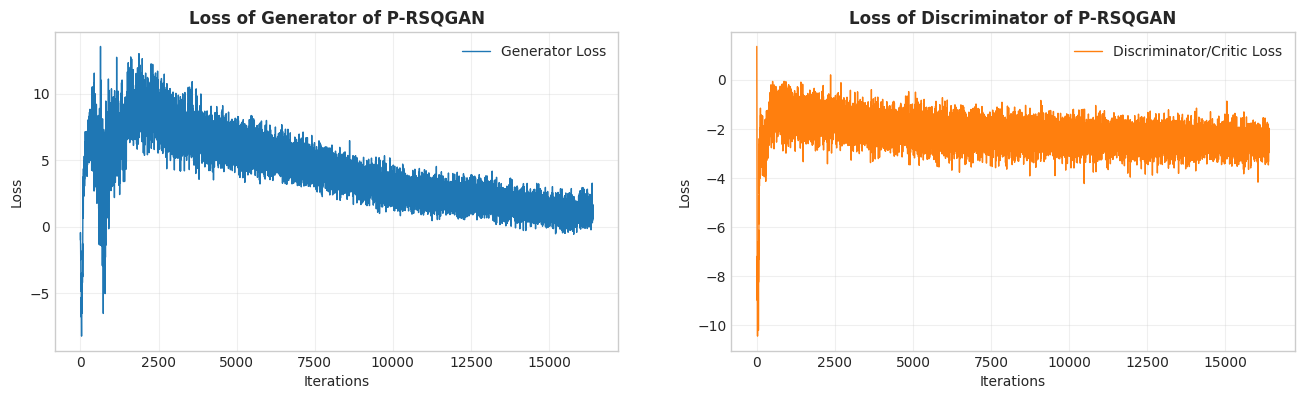

In [24]:
# Loss plots
g_losses = G_losses
d_losses = D_losses

fig = plt.figure(figsize=(16, 24))

ax1 = plt.subplot(5, 2, 1)
plt.plot(g_losses, label='Generator Loss', color='#1f77b4', linewidth=1)
plt.title("Loss of Generator of P-RSQGAN", fontsize=12, fontweight='bold')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

ax2 = plt.subplot(5, 2, 2)
plt.plot(d_losses, label='Discriminator/Critic Loss', color='#ff7f0e', linewidth=1)
plt.title("Loss of Discriminator of P-RSQGAN", fontsize=12, fontweight='bold')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

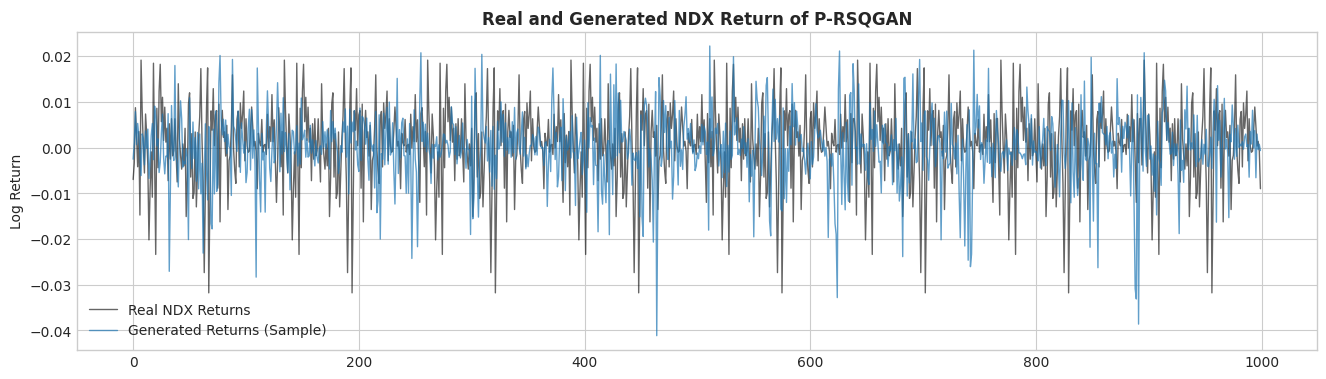

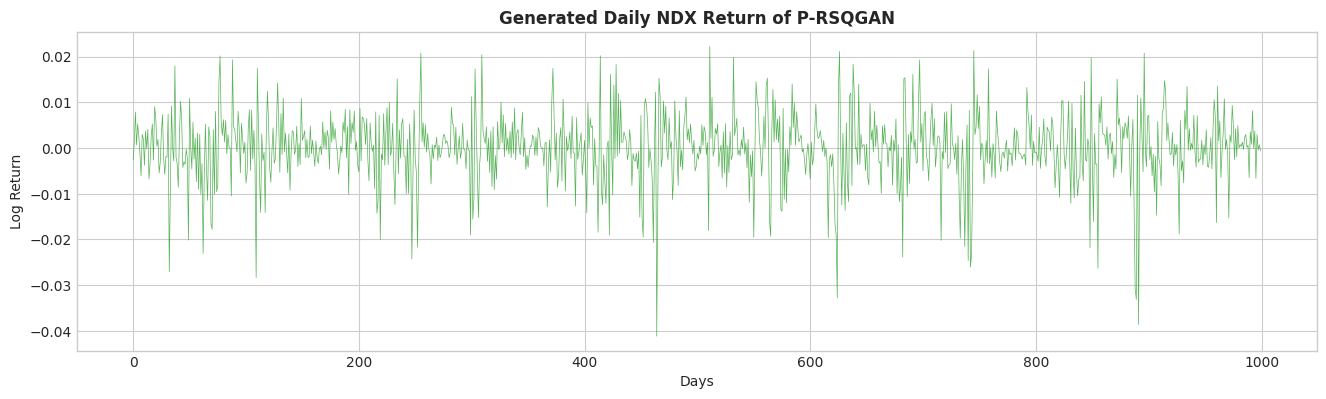

In [25]:
# Real vs Generated Return (zoom) 
fig = plt.figure(figsize=(16, 24))

ax3 = plt.subplot(5, 1, 2)
zoom_len = 1000
plt.plot(real_returns_arr[:zoom_len], label='Real NDX Returns', color='black', alpha=0.6, linewidth=1)
plt.plot(simulated_returns_paths[0][:zoom_len], label='Generated Returns (Sample)', color='#1f77b4', alpha=0.7, linewidth=1)
plt.title("Real and Generated NDX Return of P-RSQGAN", fontsize=12, fontweight='bold')
plt.ylabel("Log Return")
plt.legend()

plt.show()

# Generated Daily Return
fig = plt.figure(figsize=(16, 24))

ax4 = plt.subplot(5, 1, 3)
plt.plot(simulated_returns_paths[0], color='#2ca02c', alpha=0.8, linewidth=0.5)
plt.title("Generated Daily NDX Return of P-RSQGAN", fontsize=12, fontweight='bold')
plt.xlabel("Days")
plt.ylabel("Log Return")

plt.show()

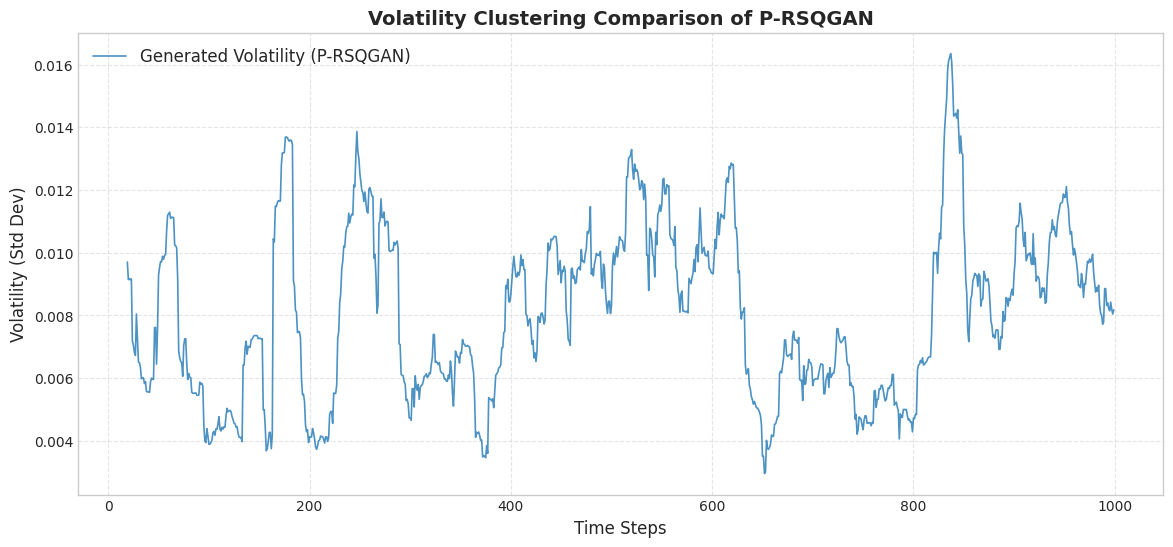

In [26]:
# Volatility clustering
WINDOW_SIZE = 20
volatility_fake = pd.Series(generated_returns).rolling(window=WINDOW_SIZE).std()

plt.figure(figsize=(14, 6))
plt.plot(volatility_fake[:1000], label='Generated Volatility (P-RSQGAN)', color='#1f77b4', alpha=0.8, linewidth=1.2)
plt.title(f'Volatility Clustering Comparison of P-RSQGAN', fontsize=14, fontweight='bold')
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Volatility (Std Dev)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, which='major', linestyle='--', alpha=0.5)
plt.show()

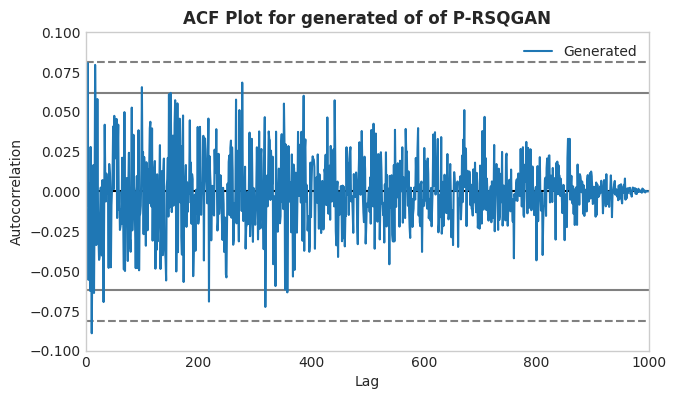

In [27]:
# ACF 
fig = plt.figure(figsize=(16, 24))
ax6 = plt.subplot(5, 2, 9)

s_fake = pd.Series(simulated_returns_paths[0])
pd.plotting.autocorrelation_plot(s_fake, label='Generated', ax=ax6)

ax6.set_title("ACF Plot for generated of of P-RSQGAN", fontsize=12, fontweight='bold')
ax6.set_xlim([0, 1000])
ax6.set_ylim([-0.1, 0.1])
ax6.legend()
plt.show()

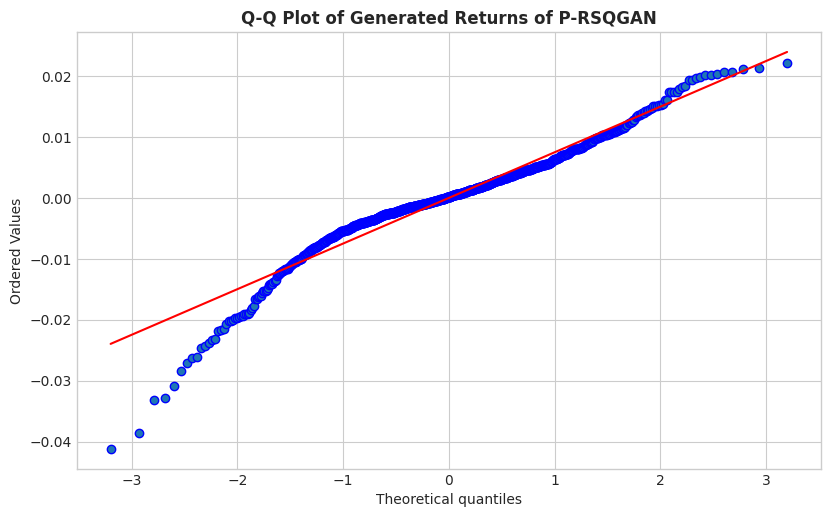

In [28]:
# Q-Q Plot
fig = plt.figure(figsize=(16, 24))
ax7 = plt.subplot(5, 2, 10)

stats.probplot(simulated_returns_paths[0], dist="norm", plot=ax7)
ax7.get_lines()[0].set_markerfacecolor('#1f77b4')
ax7.get_lines()[1].set_color('red')
ax7.set_title("Q-Q Plot of Generated Returns of P-RSQGAN", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

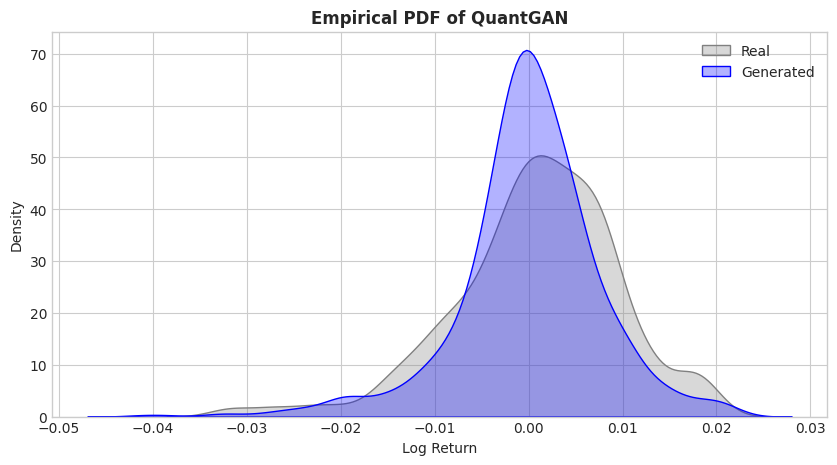

In [29]:
# KDE
plt.figure(figsize=(10, 5))
sns.kdeplot(real_returns_arr, label='Real', fill=True, color='grey', alpha=0.3)
sns.kdeplot(simulated_returns_paths[0], label='Generated', fill=True, color='blue', alpha=0.3)
plt.title("Empirical PDF of QuantGAN", fontsize=12, fontweight='bold')
plt.xlabel("Log Return")
plt.legend()
plt.show()

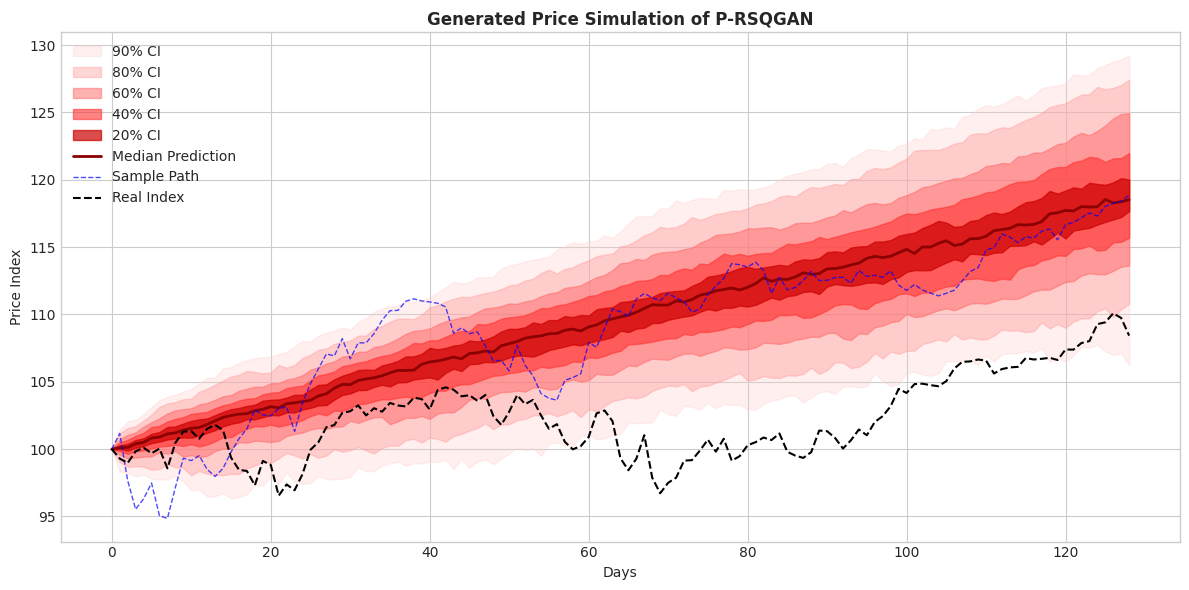

In [30]:
def returns_to_index(returns, start_price, clip_cumret=None):
    cumulative_returns = np.cumsum(returns)
    if clip_cumret is not None:
        cumulative_returns = np.clip(cumulative_returns, -clip_cumret, clip_cumret)
    index = start_price * np.exp(cumulative_returns)
    return np.insert(index, 0, start_price)

def get_real_price_path_from_csv(max_len=None, start_price=None):
    df_real = pd.read_csv(Config.DATA_PATH)

    if {'TrdDt', 'ClPr'}.issubset(df_real.columns):
        df_real['Date'] = pd.to_datetime(df_real['TrdDt'])
        df_real = df_real.sort_values('Date')
        prices = df_real['ClPr'].astype(float).values
    else:
        # NDX style
        if 'Close' in df_real.columns:
            prices = df_real['Close'].astype(float).values
        else:
            prices = df_real.iloc[:, 1].astype(float).values

    real_returns = np.diff(np.log(prices + 1e-8))

    if max_len is not None:
        real_returns = real_returns[:max_len]

    if start_price is None:
        start_price = float(prices[0])

    real_price_index = returns_to_index(real_returns, start_price)
    return real_price_index

def generate_simulated_price_paths(
    netG,
    scaler,
    regime_id=0, 
    n_simulations=300,
    gen_seq_len=None,
    S0=100.0
):
    if gen_seq_len is None:
        gen_seq_len = Config.SEQ_LEN

    netG.eval()
    simulated_price_paths = []

    with torch.no_grad():
        for _ in range(n_simulations):
            z = torch.randn(1, Config.LATENT_DIM, gen_seq_len, device=Config.DEVICE)
            y = torch.full((1,), int(regime_id), dtype=torch.long, device=Config.DEVICE)

            fake = netG(z, y).detach().cpu().numpy().squeeze()  # (L,) or (1,L) -> (L,)

            fake_returns = scaler.inverse_transform(fake.reshape(-1, 1)).flatten()
            price_path = returns_to_index(fake_returns, S0, clip_cumret=10) 

            simulated_price_paths.append(price_path)

    simulated_price_paths = np.array(simulated_price_paths)  # (n_sim, L+1)
    return simulated_price_paths

def build_fan_chart_data(simulated_price_paths, percentiles=None):
    if percentiles is None:
        percentiles = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95]
    fan_data = np.percentile(simulated_price_paths, percentiles, axis=0)
    return fan_data, percentiles

def plot_fan_chart(
    simulated_price_paths,
    fan_data,
    percentiles,
    real_price_path=None,
    title="Generated Price Simulation of P-RSQGAN"
):
    plt.style.use('seaborn-v0_8-whitegrid')

    T = simulated_price_paths.shape[1]
    x_axis = range(T)

    plt.figure(figsize=(12, 6))

    plt.fill_between(x_axis, fan_data[0], fan_data[10], color='#ffcccc', alpha=0.3, label='90% CI')
    plt.fill_between(x_axis, fan_data[1], fan_data[9],  color='#ff9999', alpha=0.4, label='80% CI')
    plt.fill_between(x_axis, fan_data[2], fan_data[8],  color='#ff6666', alpha=0.5, label='60% CI')
    plt.fill_between(x_axis, fan_data[3], fan_data[7],  color='#ff3333', alpha=0.6, label='40% CI')
    plt.fill_between(x_axis, fan_data[4], fan_data[6],  color='#cc0000', alpha=0.7, label='20% CI')

    # median
    plt.plot(x_axis, fan_data[5], color='darkred', linewidth=2, label='Median Prediction')

    # one sample path
    sample_path = simulated_price_paths[0]
    plt.plot(x_axis, sample_path, color='blue', linewidth=1, linestyle='--', alpha=0.7, label='Sample Path')

    # real path
    if real_price_path is not None:
        real_price_len = min(len(real_price_path), T)
        plt.plot(list(x_axis)[:real_price_len], real_price_path[:real_price_len],
                 color='black', linewidth=1.5, linestyle='--', label='Real Index')

    plt.title(title, fontsize=12, fontweight='bold')
    plt.xlabel("Days")
    plt.ylabel("Price Index")
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

netG = G

GEN_SEQ_LEN = Config.SEQ_LEN  
N_SIM = 300
S0 = 100.0
REGIME_ID = 0  

sim_paths = generate_simulated_price_paths(
    netG=netG,
    scaler=scaler,
    regime_id=REGIME_ID,
    n_simulations=N_SIM,
    gen_seq_len=GEN_SEQ_LEN,
    S0=S0
)

fan_data, pct_list = build_fan_chart_data(sim_paths)

real_path = get_real_price_path_from_csv(
    max_len=GEN_SEQ_LEN,
    start_price=S0
)

plot_fan_chart(
    simulated_price_paths=sim_paths,
    fan_data=fan_data,
    percentiles=pct_list,
    real_price_path=real_path,
    title=f"Generated Price Simulation of P-RSQGAN"
)
